In [66]:
import torch
import numpy as np
from torchvision import datasets 
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

In [67]:
num_workers = 0
batch_size = 20
valid_size = 0.2

In [68]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [69]:
train_data = datasets.CIFAR10('data', train = True, download = True, transform = transform)

Files already downloaded and verified


In [70]:
test_data  = datasets.CIFAR10('data_test', train = False, download = True, transform = transform)

Files already downloaded and verified


In [71]:
num_train = len(train_data)
print(num_train)
indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler =train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler =valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers=num_workers)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

50000


In [72]:
train_on_gpu = torch.cuda.is_available()

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

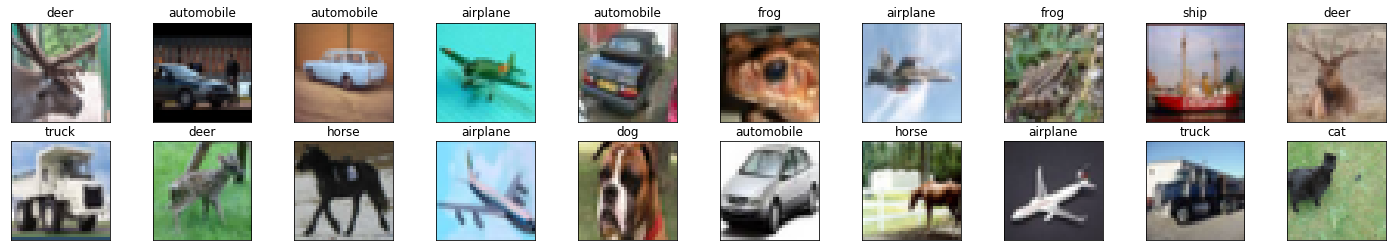

In [74]:
dataiter = iter(train_loader)
images, label = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[label[idx]])

### Defining The CNN architecture

In [75]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return x


In [76]:
model = Net()

print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [77]:
if train_on_gpu:
    model.cuda()

In [78]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [80]:
epochs = 30

valid_loss_min = np.Inf

for epoch in range(1, epochs+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * data.size(0)
        
        
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
        
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.085222 	Validation Loss: 1.880384
Validation loss decreased (inf --> 1.880384).  Saving model ...
Epoch: 2 	Training Loss: 1.690811 	Validation Loss: 1.537015
Validation loss decreased (1.880384 --> 1.537015).  Saving model ...
Epoch: 3 	Training Loss: 1.480381 	Validation Loss: 1.392694
Validation loss decreased (1.537015 --> 1.392694).  Saving model ...
Epoch: 4 	Training Loss: 1.365775 	Validation Loss: 1.301595
Validation loss decreased (1.392694 --> 1.301595).  Saving model ...
Epoch: 5 	Training Loss: 1.273927 	Validation Loss: 1.219519
Validation loss decreased (1.301595 --> 1.219519).  Saving model ...
Epoch: 6 	Training Loss: 1.193206 	Validation Loss: 1.138856
Validation loss decreased (1.219519 --> 1.138856).  Saving model ...
Epoch: 7 	Training Loss: 1.118366 	Validation Loss: 1.069140
Validation loss decreased (1.138856 --> 1.069140).  Saving model ...
Epoch: 8 	Training Loss: 1.056092 	Validation Loss: 1.038895
Validation loss decreased (1.06914

In [81]:
model.load_state_dict(torch.load('model_cifar.pt'))

In [92]:
itemArray = ['airplane', 'automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [120]:
data_test, target_test = next(iter(test_loader))

In [121]:
prediction = model(data_test)
ps = F.softmax(prediction, dim = 1)

In [122]:
result = ps.topk(1, dim = 1)

In [123]:
for i in range(20):
    print(f"Model prediction: {itemArray[result[1][i].item()]}, probability: {result[0][i].item()}, Label: {itemArray[target_test[i].item()]}")

Model prediction using the topk method: Cat, probability: 0.6635581254959106, Label: Cat
Model prediction using the topk method: Ship, probability: 0.8903033137321472, Label: Ship
Model prediction using the topk method: airplane, probability: 0.5032356977462769, Label: Ship
Model prediction using the topk method: airplane, probability: 0.9440774917602539, Label: airplane
Model prediction using the topk method: Frog, probability: 0.9063953161239624, Label: Frog
Model prediction using the topk method: Frog, probability: 0.780595064163208, Label: Frog
Model prediction using the topk method: automobile, probability: 0.9262019991874695, Label: automobile
Model prediction using the topk method: Bird, probability: 0.787081241607666, Label: Frog
Model prediction using the topk method: Cat, probability: 0.9385862350463867, Label: Cat
Model prediction using the topk method: automobile, probability: 0.8513086438179016, Label: automobile
Model prediction using the topk method: airplane, probabilit